# Textual 终端UI组件

`PnTextual` 组件允许在 Panel 应用程序中渲染 [Textual](https://textual.textualize.io/) 应用程序。它通过补丁方式实现了一个自定义 Panel 驱动程序，并将应用程序渲染到 [`Terminal`](../widgets/Terminal.ipynb) 组件中，完全支持鼠标和键盘事件。

底层实现为`panel.pane.Textual`，参数基本一致，参考文档：https://panel.holoviz.org/reference/panes/Textual.html


In [1]:
##ignore
%load_ext vuepy
from panel_vuepy import vpanel


## 基本用法

需要注意以下几点：

- 一旦 `App` 实例被绑定到 `PnTextual` 组件，它就不能在另一个组件中重用，并且每个 App 实例只能绑定到单个会话。
- 应用程序必须在与它将运行的服务器相同的线程上实例化，例如，如果您使用 `pn.serve(..., threaded=True)` 提供应用程序，则必须在函数内部实例化 `App`。

`PnTextual` 组件可以直接接收 Textual `App`，Panel 将处理其余部分，即启动应用程序、处理输入、重新渲染等。换句话说，应用程序将像在常规终端中运行一样工作。

让我们从一个非常简单的例子开始：


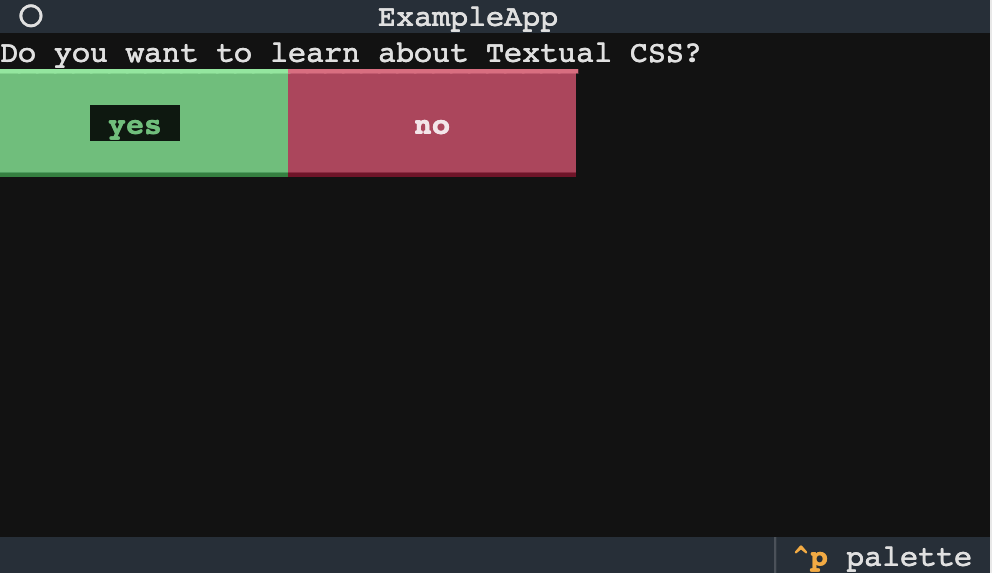

In [2]:
%%vuepy_run --plugins vpanel --show-code --backend='panel'
<template>
  <PnTextual :object="example_app" :width="500" :height="300" />
</template>
<script lang='py'>
from textual.app import App, ComposeResult
from textual.containers import Container, Horizontal
from textual.widgets import Button, Footer, Header, Static

QUESTION = "Do you want to learn about Textual CSS?"

class ExampleApp(App):
    def compose(self) -> ComposeResult:
        yield Header()
        yield Footer()
        yield Container(
            Static(QUESTION, classes="question"),
            Horizontal(
                Button("yes", variant="success"),
                Button("no", variant="error"),
                classes="buttons",
            ),
            id="dialog",
        )

example_app = ExampleApp()
</script>

{"vue": "<!-- --plugins vpanel --show-code --backend='panel' -->\n<template>\n  <PnTextual :object=\"example_app\" :width=\"500\" :height=\"300\" />\n</template>\n<script lang='py'>\nfrom textual.app import App, ComposeResult\nfrom textual.containers import Container, Horizontal\nfrom textual.widgets import Button, Footer, Header, Static\n\nQUESTION = \"Do you want to learn about Textual CSS?\"\n\nclass ExampleApp(App):\n    def compose(self) -> ComposeResult:\n        yield Header()\n        yield Footer()\n        yield Container(\n            Static(QUESTION, classes=\"question\"),\n            Horizontal(\n                Button(\"yes\", variant=\"success\"),\n                Button(\"no\", variant=\"error\"),\n                classes=\"buttons\",\n            ),\n            id=\"dialog\",\n        )\n\nexample_app = ExampleApp()\n</script>\n", "setup": ""}


Column(name='root')
    [0] Column(name='body')
        [0] Column
            [0] Textual(ExampleApp, height=300, sizing_mode='fixed', width=500)


这对于简单的应用程序和更复杂的应用程序都适用。作为示例，这里我们嵌入了 Textual 文档中的计算器示例应用程序：


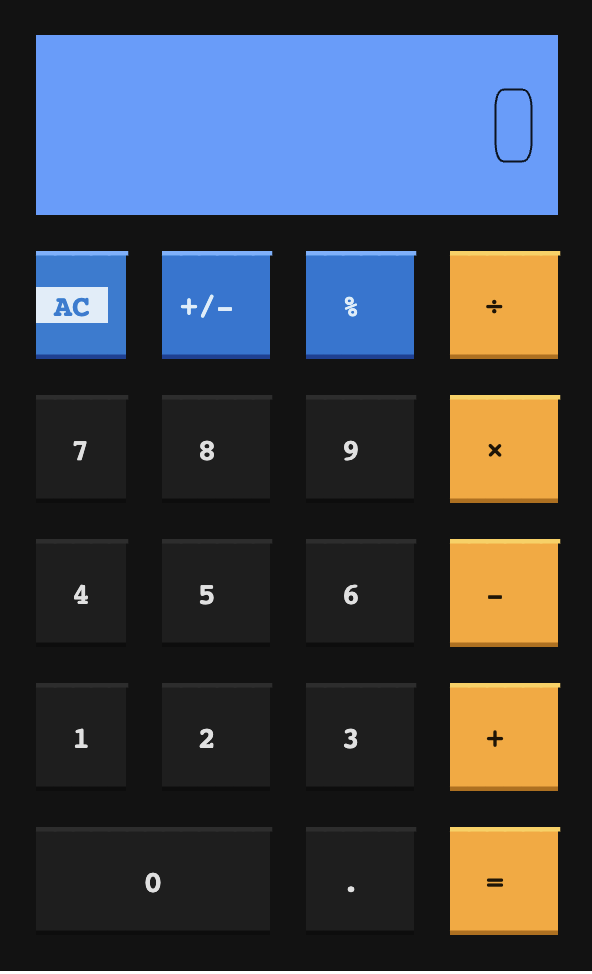

In [3]:
%%vuepy_run --plugins vpanel --show-code --backend='panel'
<template>
  <PnTextual :object="calculator" :height="500" :width="300" />
</template>
<script lang='py'>
from decimal import Decimal

from textual import events, on
from textual.app import App, ComposeResult
from textual.containers import Container
from textual.css.query import NoMatches
from textual.reactive import var
from textual.widgets import Button, Digits

from pathlib import Path
import requests

def _download_file_if_not_exists(url: str, local_path: str) -> Path:
    local_file_path = Path(local_path)

    if not local_file_path.exists():
        response = requests.get(url)
        response.raise_for_status()
        local_file_path.write_bytes(response.content)

    return local_file_path


file_url = "https://raw.githubusercontent.com/holoviz/panel/main/examples/assets/calculator.tcss"
local_file_path = "calculator.tcss"
calculator_tcss = _download_file_if_not_exists(file_url, local_file_path)


class CalculatorApp(App):
    """一个可用的'桌面'计算器。"""

    CSS_PATH = calculator_tcss.absolute()

    numbers = var("0")
    show_ac = var(True)
    left = var(Decimal("0"))
    right = var(Decimal("0"))
    value = var("")
    operator = var("plus")

    NAME_MAP = {
        "asterisk": "multiply",
        "slash": "divide",
        "underscore": "plus-minus",
        "full_stop": "point",
        "plus_minus_sign": "plus-minus",
        "percent_sign": "percent",
        "equals_sign": "equals",
        "minus": "minus",
        "plus": "plus",
    }

    def watch_numbers(self, value: str) -> None:
        """当 numbers 更新时调用。"""
        self.query_one("#numbers", Digits).update(value)

    def compute_show_ac(self) -> bool:
        """计算是显示 AC 还是 C 按钮"""
        return self.value in ("", "0") and self.numbers == "0"

    def watch_show_ac(self, show_ac: bool) -> None:
        """当 show_ac 更改时调用。"""
        self.query_one("#c").display = not show_ac
        self.query_one("#ac").display = show_ac

    def compose(self) -> ComposeResult:
        """添加我们的按钮。"""
        with Container(id="calculator"):
            yield Digits(id="numbers")
            yield Button("AC", id="ac", variant="primary")
            yield Button("C", id="c", variant="primary")
            yield Button("+/-", id="plus-minus", variant="primary")
            yield Button("%", id="percent", variant="primary")
            yield Button("÷", id="divide", variant="warning")
            yield Button("7", id="number-7", classes="number")
            yield Button("8", id="number-8", classes="number")
            yield Button("9", id="number-9", classes="number")
            yield Button("×", id="multiply", variant="warning")
            yield Button("4", id="number-4", classes="number")
            yield Button("5", id="number-5", classes="number")
            yield Button("6", id="number-6", classes="number")
            yield Button("-", id="minus", variant="warning")
            yield Button("1", id="number-1", classes="number")
            yield Button("2", id="number-2", classes="number")
            yield Button("3", id="number-3", classes="number")
            yield Button("+", id="plus", variant="warning")
            yield Button("0", id="number-0", classes="number")
            yield Button(".", id="point")
            yield Button("=", id="equals", variant="warning")

    def on_key(self, event: events.Key) -> None:
        """当用户按下键时调用。"""

        def press(button_id: str) -> None:
            """按下一个按钮，如果它存在的话。"""
            try:
                self.query_one(f"#{button_id}", Button).press()
            except NoMatches:
                pass

        key = event.key
        if key.isdecimal():
            press(f"number-{key}")
        elif key == "c":
            press("c")
            press("ac")
        else:
            button_id = self.NAME_MAP.get(key)
            if button_id is not None:
                press(self.NAME_MAP.get(key, key))

    @on(Button.Pressed, ".number")
    def number_pressed(self, event: Button.Pressed) -> None:
        """按下了数字。"""
        assert event.button.id is not None
        number = event.button.id.partition("-")[-1]
        self.numbers = self.value = self.value.lstrip("0") + number

    @on(Button.Pressed, "#plus-minus")
    def plus_minus_pressed(self) -> None:
        """按下 + / -"""
        self.numbers = self.value = str(Decimal(self.value or "0") * -1)

    @on(Button.Pressed, "#percent")
    def percent_pressed(self) -> None:
        """按下 %"""
        self.numbers = self.value = str(Decimal(self.value or "0") / Decimal(100))

    @on(Button.Pressed, "#point")
    def pressed_point(self) -> None:
        """按下 ."""
        if "." not in self.value:
            self.numbers = self.value = (self.value or "0") + "."

    @on(Button.Pressed, "#ac")
    def pressed_ac(self) -> None:
        """按下 AC"""
        self.value = ""
        self.left = self.right = Decimal(0)
        self.operator = "plus"
        self.numbers = "0"

    @on(Button.Pressed, "#c")
    def pressed_c(self) -> None:
        """按下 C"""
        self.value = ""
        self.numbers = "0"

    def _do_math(self) -> None:
        """执行数学运算：LEFT OPERATOR RIGHT"""
        try:
            if self.operator == "plus":
                self.left += self.right
            elif self.operator == "minus":
                self.left -= self.right
            elif self.operator == "divide":
                self.left /= self.right
            elif self.operator == "multiply":
                self.left *= self.right
            self.numbers = str(self.left)
            self.value = ""
        except Exception:
            self.numbers = "Error"

    @on(Button.Pressed, "#plus,#minus,#divide,#multiply")
    def pressed_op(self, event: Button.Pressed) -> None:
        """按下了算术运算之一。"""
        self.right = Decimal(self.value or "0")
        self._do_math()
        assert event.button.id is not None
        self.operator = event.button.id

    @on(Button.Pressed, "#equals")
    def pressed_equals(self) -> None:
        """按下 ="""
        if self.value:
            self.right = Decimal(self.value)
        self._do_math()


calculator = CalculatorApp()
</script>

{"vue": "<!-- --plugins vpanel --show-code --backend='panel' -->\n<template>\n  <PnTextual :object=\"calculator\" :height=\"500\" :width=\"300\" />\n</template>\n<script lang='py'>\nfrom decimal import Decimal\n\nfrom textual import events, on\nfrom textual.app import App, ComposeResult\nfrom textual.containers import Container\nfrom textual.css.query import NoMatches\nfrom textual.reactive import var\nfrom textual.widgets import Button, Digits\n\nfrom pathlib import Path\nimport requests\n\ndef _download_file_if_not_exists(url: str, local_path: str) -> Path:\n    local_file_path = Path(local_path)\n\n    if not local_file_path.exists():\n        response = requests.get(url)\n        response.raise_for_status()\n        local_file_path.write_bytes(response.content)\n\n    return local_file_path\n\n\nfile_url = \"https://raw.githubusercontent.com/holoviz/panel/main/examples/assets/calculator.tcss\"\nlocal_file_path = \"calculator.tcss\"\ncalculator_tcss = _download_file_if_not_exists(fi

Column(name='root')
    [0] Column(name='body')
        [0] Column
            [0] Textual(CalculatorApp, height=500, sizing_mode='fixed', width=300)


## API

### 属性

| 属性名            | 说明                          | 类型                                                           | 默认值 |
| ---------------- | ----------------------------- | ---------------------------------------------------------------| ------- |
| object           | 要渲染的 Textual 应用程序      | ^[textual.app.App]                                             | None |
| sizing_mode      | 尺寸调整模式                  | ^[str]                                                         | 'fixed'  |
| width            | 宽度                          | ^[int, str]                                                    | None    |
| height           | 高度                          | ^[int, str]                                                    | None    |
| min_width        | 最小宽度                      | ^[int]                                                         | None    |
| min_height       | 最小高度                      | ^[int]                                                         | None    |
| max_width        | 最大宽度                      | ^[int]                                                         | None    |
| max_height       | 最大高度                      | ^[int]                                                         | None    |
| margin           | 外边距                        | ^[int, tuple]                                                  | 5       |
| css_classes      | CSS类名列表                   | ^[list]                                                        | []      |

### Slots

| 插槽名   | 说明               |
| ---     | ---               |
| default | 自定义默认内容      |


## Controls

In [4]:
##controls
import panel as pn
from textual.app import App, ComposeResult
from textual.containers import Container, Horizontal
from textual.widgets import Button, Footer, Header, Static

pn.extension("terminal")

QUESTION = "Do you want to learn about Textual CSS?"

class ExampleApp(App):
    def compose(self) -> ComposeResult:
        yield Header()
        yield Footer()
        yield Container(
            Static(QUESTION, classes="question"),
            Horizontal(
                Button("Yes", variant="success"),
                Button("No", variant="error"),
                classes="buttons",
            ),
            id="dialog",
        )

example_app = ExampleApp()

t = pn.pane.Textual(example_app, width=300, height=200)
pn.Row(t.controls(), t)

Row
    [0] WidgetBox(margin=(5, 10), name='Layout')
        [0] StaticText(value='<b>Layout</b>')
        [1] TextInput(description='String identifier f..., name='Name', value='Textual00149')
        [2] LiteralInput(description='Whether the object should..., name='Align', serializer='json', value='start')
        [3] LiteralInput(description='Describes the proportiona..., name='Aspect ratio', serializer='json')
        [4] ListInput(description='CSS classes t..., name='Css classes', serializer='json', type=<class 'list'>)
        [5] IntInput(description='The height of the compone..., name='Height', start=0, value=200)
        [6] IntInput(description='Minimal width o..., name='Min width', start=0)
        [7] IntInput(description='Minimal height o..., name='Min height', start=0)
        [8] IntInput(description='Maximum width o..., name='Max width', start=0)
        [9] IntInput(description='Maximum height o..., name='Max height', start=0)
        [10] LiteralInput(description='Allows to create addition..., name='Margin', serializer='json', value=(5, 10))
        [11] DictInput(description='Dictionary of C..., name='Styles', serializer='json', type=<class 'dict'>)
        [12] ListInput(description='List of arbitrary t..., name='Tags', serializer='json', type=<class 'list'>)
        [13] IntInput(description='The width of the componen..., name='Width', start=0, value=300)
        [14] Select(description='Describes how the compone..., name='Width policy', options=OrderedDict([('auto', ...]), value='auto')
        [15] Select(description='Describes how the compone..., name='Height policy', options=OrderedDict([('auto', ...]), value='auto')
        [16] Select(description='How the component should ..., name='Sizing mode', options=OrderedDict([('fixed', ...]), value='fixed')
        [17] Checkbox(name='Visible', value=True)
    [1] Textual(ExampleApp, height=200, sizing_mode='fixed', width=300)